# Within-Category Exemplar Variability

Load all grouped average embeddings (one per subject × age_mo per category), then quantify **within-category exemplar variability** using:

1. **Distance to centroid**: For each category, centroid = mean embedding; then mean L2 distance (and std) from each exemplar to the centroid. Lower = tighter category.
2. **Mean pairwise distance**: Average L2 distance over all pairs of exemplars within the category. Captures overall spread.
3. **Per-exemplar variance**: Mean per-dimension variance (trace of covariance / dim) across exemplars. Standard variability measure.
4. **Cosine similarity to centroid**: Mean cosine similarity of each exemplar to the category centroid. Higher = more coherent.

Directory layout: `{grouped_embeddings_dir}/{category}/{subject_id}_{age_mo}_month_level_avg.npy`

## Setup and configuration

In [27]:
# Use conda env: conda activate vislearnlabpy (required for THINGS CLIP .docs)
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print("Imports OK.")

Imports OK.


In [28]:
# Run all four: bv_clip, bv_dinov3, things_clip, things_dinov3 (variability CSVs + t-SNE per dataset)
CONFIGS = [
    ("bv", "clip"), ("bv", "dinov3"), ("things", "clip"), ("things", "dinov3"),
]

# BV: grouped embeddings dirs (normalized age-month level)
GROUPED_EMBEDDINGS_BASE = "/data2/dataset/babyview/868_hours/outputs/yoloe_cdi_embeddings"
GROUPED_EMBEDDINGS_DIRS = {
    "clip": Path(f"{GROUPED_EMBEDDINGS_BASE}/clip_embeddings_grouped_by_age-mo_normalized"),
    "dinov3": Path(f"{GROUPED_EMBEDDINGS_BASE}/facebook_dinov3-vitb16-pretrain-lvd1689m_grouped_by_age-mo_normalized"),
}

# THINGS: per-exemplar .npy in category folders
THINGS_DINOV3_DIR = Path("/ccn2/dataset/babyview/outputs_20250312/image_embeddings/things_bv_overlapping_categories_corrected/facebook_dinov3-vitb16-pretrain-lvd1689m")
THINGS_CLIP_NPY_DIR = Path("/ccn2/dataset/babyview/outputs_20250312/things_bv_overlapping_categories_corrected/embeddings/image_embeddings/clip_image_embeddings_npy_by_category")

# Optional: restrict to categories (one per line)
categories_file = Path("../../../data/things_bv_overlap_categories_exclude_zero_precisions.txt")
allowed_categories = None
if categories_file.exists():
    with open(categories_file) as f:
        allowed_categories = set(line.strip() for line in f if line.strip())
    print(f"Using {len(allowed_categories)} categories from {categories_file.name}")

excluded_subject = "00270001"
min_exemplars = 2
print(f"Will run: {[f'{ds}_{et}' for ds, et in CONFIGS]}")


Using 163 categories from things_bv_overlap_categories_exclude_zero_precisions.txt
Will run: ['bv_clip', 'bv_dinov3', 'things_clip', 'things_dinov3']


## Load all exemplar embeddings per category

In [29]:
def load_all_exemplars_by_category(grouped_dir, allowed_categories=None, excluded_subject=None, min_exemplars=2):
    """Load every {subject_id}_{age_mo}_month_level_avg.npy per category. Returns category_embeddings, category_exemplar_ids."""
    grouped_dir = Path(grouped_dir)
    if not grouped_dir.exists():
        raise FileNotFoundError(f"Not found: {grouped_dir}")
    category_folders = [f for f in grouped_dir.iterdir() if f.is_dir()]
    if allowed_categories is not None:
        category_folders = [f for f in category_folders if f.name in allowed_categories]
    category_folders = sorted(category_folders)
    category_embeddings = {}
    category_exemplar_ids = {}
    for cat_folder in tqdm(category_folders, desc="Loading categories"):
        cat_name = cat_folder.name
        files = list(cat_folder.glob("*.npy"))
        embs, ids = [], []
        for f in files:
            stem = f.stem
            parts = stem.split("_")
            if len(parts) < 2:
                continue
            subject_id, age_mo = parts[0], None
            try:
                age_mo = int(parts[1])
            except ValueError:
                continue
            if excluded_subject and subject_id == excluded_subject:
                continue
            try:
                e = np.load(f)
                e = np.asarray(e, dtype=np.float64).flatten()
                embs.append(e)
                ids.append((subject_id, age_mo))
            except Exception as err:
                print(f"Skip {f}: {err}")
                continue
        if len(embs) >= min_exemplars:
            category_embeddings[cat_name] = np.array(embs)
            category_exemplar_ids[cat_name] = ids
    return category_embeddings, category_exemplar_ids

def load_embeddings_for_config(data_source, embedding_type):
    """Load category_embeddings and category_exemplar_ids for (data_source, embedding_type)."""
    if data_source == "bv":
        return load_all_exemplars_by_category(
            GROUPED_EMBEDDINGS_DIRS[embedding_type],
            allowed_categories=allowed_categories,
            excluded_subject=excluded_subject,
            min_exemplars=min_exemplars,
        )
    from load_things_embeddings import load_things_dinov3_from_dir, load_things_clip_from_dir
    if embedding_type == "dinov3":
        return load_things_dinov3_from_dir(THINGS_DINOV3_DIR, allowed_categories=allowed_categories, min_exemplars=min_exemplars)
    return load_things_clip_from_dir(THINGS_CLIP_NPY_DIR, allowed_categories=allowed_categories, min_exemplars=min_exemplars)

print("Load functions defined.")


Load functions defined.


In [30]:
# Load CDI mapping (used per config to build cdi_to_objects / cdi_categories)
cdi_path = Path("../../../data/cdi_words.csv")
cdi_df = pd.read_csv(cdi_path)
word_to_cdi = dict(zip(cdi_df["uni_lemma"], cdi_df["category"]))

def object_category_to_cdi(obj_cat):
    if obj_cat in word_to_cdi:
        return word_to_cdi[obj_cat]
    c = obj_cat.lower().strip()
    for v in [c, c.rstrip("s"), c.rstrip("es"), c.replace("_", " "), c.replace("-", " ")]:
        if v in word_to_cdi:
            return word_to_cdi[v]
    return None

def build_cdi_mapping(category_embeddings):
    obj_to_cdi = {cat: object_category_to_cdi(cat) for cat in category_embeddings}
    cdi_to_objects = defaultdict(list)
    for obj_cat, cdi_cat in obj_to_cdi.items():
        if cdi_cat is not None:
            cdi_to_objects[cdi_cat].append(obj_cat)
    cdi_categories = sorted(cdi_to_objects.keys())
    return cdi_to_objects, cdi_categories

print("CDI mapping loaded.")


CDI mapping loaded.


In [31]:
from sklearn.manifold import TSNE

def _mean_pairwise_l2(X):
    n = X.shape[0]
    if n < 2:
        return np.nan
    max_pairs = 50_000
    total_pairs = n * (n - 1) // 2
    if total_pairs <= max_pairs:
        pairs = list(combinations(range(n), 2))
        dists = [np.linalg.norm(X[i] - X[j]) for i, j in pairs]
    else:
        idx = np.random.default_rng(42).choice(n, size=min(2 * max_pairs, n * 2), replace=True)
        idx = idx.reshape(-1, 2)
        idx = idx[idx[:, 0] != idx[:, 1]][:max_pairs]
        dists = [np.linalg.norm(X[i] - X[j]) for i, j in idx]
    return np.mean(dists)

def _variability_measures(X):
    n, d = X.shape
    centroid = X.mean(axis=0)
    diffs = X - centroid
    dists_to_centroid = np.linalg.norm(diffs, axis=1)
    mean_d = float(np.mean(dists_to_centroid))
    std_d = float(np.std(dists_to_centroid))
    c_norm = centroid / (np.linalg.norm(centroid) + 1e-12)
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    cos_to_centroid = (X_norm @ c_norm)
    mean_cos = float(np.mean(cos_to_centroid))
    var_per_dim = np.var(X, axis=0)
    mean_var = float(np.mean(var_per_dim))
    mean_pw = _mean_pairwise_l2(X)
    return {"mean_dist_to_centroid": mean_d, "std_dist_to_centroid": std_d, "mean_pairwise_l2": mean_pw,
            "mean_per_dim_variance": mean_var, "mean_cosine_to_centroid": mean_cos, "n_exemplars": n}

out_dir = Path(".")
random_state = 42

for data_source, embedding_type in CONFIGS:
    output_prefix = f"{data_source}_{embedding_type}"
    print(f"\n--- {output_prefix} ---")
    category_embeddings, _ = load_embeddings_for_config(data_source, embedding_type)
    cdi_to_objects, cdi_categories = build_cdi_mapping(category_embeddings)
    n_cats = len(category_embeddings)
    n_exemplars_total = sum(category_embeddings[c].shape[0] for c in category_embeddings)
    print(f"  Loaded {n_cats} categories, {n_exemplars_total} total exemplars")

    # Variability: same for both BV and THINGS — per object category (centroid per category)
    results = []
    for cat in tqdm(category_embeddings, desc=f"  Variability {output_prefix}"):
        X = category_embeddings[cat]
        m = _variability_measures(X)
        m["category"] = cat
        results.append(m)
    variability_df = pd.DataFrame(results).sort_values("mean_dist_to_centroid", ascending=False).reset_index(drop=True)
    out_csv = out_dir / f"{output_prefix}_within_category_variability.csv"
    variability_df.to_csv(out_csv, index=False)
    print(f"  Saved {out_csv.name}")

    # t-SNE per CDI category
    tsne_out_dir = Path(f"{output_prefix}_tsne_by_cdi_category")
    tsne_out_dir.mkdir(exist_ok=True)
    for cdi_cat in tqdm(cdi_categories, desc=f"  t-SNE {output_prefix}"):
        obj_cats = cdi_to_objects[cdi_cat]
        embs_list = []
        labels_list = []
        for obj_cat in obj_cats:
            X = category_embeddings[obj_cat]
            n = X.shape[0]
            embs_list.append(X)
            labels_list.extend([obj_cat] * n)
        X_all = np.vstack(embs_list)
        labels = np.array(labels_list)
        if X_all.shape[0] < 2:
            continue
        perplexity = min(30, max(5, (X_all.shape[0] - 1) // 3))
        reducer = TSNE(n_components=2, random_state=random_state, perplexity=perplexity)
        coords = reducer.fit_transform(X_all)
        unique_obj = sorted(np.unique(labels))
        n_obj = len(unique_obj)
        colors = plt.cm.tab20(np.linspace(0, 1, max(n_obj, 1))) if n_obj <= 20 else plt.cm.tab20b(np.linspace(0, 1, n_obj))
        obj_to_color = dict(zip(unique_obj, colors[:n_obj]))
        fig, ax = plt.subplots(figsize=(8, 6))
        for obj_cat in unique_obj:
            mask = labels == obj_cat
            ax.scatter(coords[mask, 0], coords[mask, 1], c=[obj_to_color[obj_cat]], label=obj_cat, alpha=0.7, s=25)
        ax.set_title(f"t-SNE: {cdi_cat} (n={X_all.shape[0]} exemplars, {n_obj} object categories)")
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=7)
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        plt.tight_layout()
        safe_name = cdi_cat.replace(" ", "_").replace("/", "-")
        plt.savefig(tsne_out_dir / f"{safe_name}.png", dpi=150, bbox_inches="tight")
        plt.close()
    print(f"  Saved t-SNE to {tsne_out_dir}/")

print("\nAll four configs done. Run the comparison cell below for BV vs THINGS plots.")


--- bv_clip ---


Loading categories: 100%|██████████| 163/163 [00:01<00:00, 118.06it/s]


  Loaded 163 categories, 34550 total exemplars


  Variability bv_clip: 100%|██████████| 163/163 [00:09<00:00, 16.76it/s]


  Saved bv_clip_within_category_variability.csv


  t-SNE bv_clip: 100%|██████████| 9/9 [01:19<00:00,  8.80s/it]


  Saved t-SNE to bv_clip_tsne_by_cdi_category/

--- bv_dinov3 ---


Loading categories: 100%|██████████| 163/163 [00:01<00:00, 123.77it/s]


  Loaded 163 categories, 34550 total exemplars


  Variability bv_dinov3: 100%|██████████| 163/163 [00:10<00:00, 15.92it/s]


  Saved bv_dinov3_within_category_variability.csv


  t-SNE bv_dinov3: 100%|██████████| 9/9 [01:20<00:00,  9.00s/it]


  Saved t-SNE to bv_dinov3_tsne_by_cdi_category/

--- things_clip ---
  Loaded 162 categories, 2186 total exemplars


  Variability things_clip: 100%|██████████| 162/162 [00:00<00:00, 3548.52it/s]


  Saved things_clip_within_category_variability.csv


  t-SNE things_clip: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


  Saved t-SNE to things_clip_tsne_by_cdi_category/

--- things_dinov3 ---
  Loaded 163 categories, 2361 total exemplars


  Variability things_dinov3: 100%|██████████| 163/163 [00:00<00:00, 3082.39it/s]


  Saved things_dinov3_within_category_variability.csv


  t-SNE things_dinov3: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]

  Saved t-SNE to things_dinov3_tsne_by_cdi_category/

All four configs done. Run the comparison cell below for BV vs THINGS plots.


## Compute within-category variability measures

In [32]:
def mean_pairwise_l2(X):
    """Mean L2 distance over all pairs of rows in X (n, d)."""
    n = X.shape[0]
    if n < 2:
        return np.nan
    # For large n, sample pairs to avoid O(n^2) memory
    max_pairs = 50_000
    total_pairs = n * (n - 1) // 2
    if total_pairs <= max_pairs:
        pairs = list(combinations(range(n), 2))
        dists = [np.linalg.norm(X[i] - X[j]) for i, j in pairs]
    else:
        idx = np.random.default_rng(42).choice(n, size=min(2 * max_pairs, n * 2), replace=True)
        idx = idx.reshape(-1, 2)
        idx = idx[idx[:, 0] != idx[:, 1]][:max_pairs]
        dists = [np.linalg.norm(X[i] - X[j]) for i, j in idx]
    return np.mean(dists)

def variability_measures(X):
    """
    X: (n_exemplars, dim). Returns dict of:
    - mean_dist_to_centroid, std_dist_to_centroid
    - mean_pairwise_l2
    - mean_per_dim_variance (trace(cov)/dim)
    - mean_cosine_to_centroid
    - n_exemplars
    """
    n, d = X.shape
    centroid = X.mean(axis=0)
    # L2 distances to centroid
    diffs = X - centroid
    dists_to_centroid = np.linalg.norm(diffs, axis=1)
    mean_d = float(np.mean(dists_to_centroid))
    std_d = float(np.std(dists_to_centroid))
    # Cosine to centroid (centroid and rows normalized)
    c_norm = centroid / (np.linalg.norm(centroid) + 1e-12)
    X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
    cos_to_centroid = (X_norm @ c_norm)
    mean_cos = float(np.mean(cos_to_centroid))
    # Per-dimension variance (average variance across dimensions)
    var_per_dim = np.var(X, axis=0)
    mean_var = float(np.mean(var_per_dim))
    # Mean pairwise L2
    mean_pw = mean_pairwise_l2(X)
    return {
        "mean_dist_to_centroid": mean_d,
        "std_dist_to_centroid": std_d,
        "mean_pairwise_l2": mean_pw,
        "mean_per_dim_variance": mean_var,
        "mean_cosine_to_centroid": mean_cos,
        "n_exemplars": n,
    }

print("Variability functions defined.")


Variability functions defined.


## Summary stats and save

In [33]:
# Optional: inspect one config (CSVs and t-SNE were saved by the "Run all configs" cell above)
out_dir = Path(".")
inspect_prefix = "bv_clip"  # or bv_dinov3, things_clip, things_dinov3
variability_df = pd.read_csv(out_dir / f"{inspect_prefix}_within_category_variability.csv")
print(f"Inspection: {inspect_prefix} ({len(variability_df)} rows)")
print(variability_df[["mean_dist_to_centroid", "mean_pairwise_l2", "mean_per_dim_variance", "mean_cosine_to_centroid"]].describe())
variability_df.head(10)


Inspection: bv_clip (163 rows)
       mean_dist_to_centroid  mean_pairwise_l2  mean_per_dim_variance  \
count             163.000000        163.000000             163.000000   
mean               17.895359         25.910574               0.822558   
std                 7.924129         11.406760               0.656943   
min                 4.990400          7.245543               0.056645   
25%                11.416354         16.555973               0.292547   
50%                15.468522         22.663398               0.561797   
75%                24.515833         35.546508               1.307339   
max                39.078043         56.217698               3.032533   

       mean_cosine_to_centroid  
count               163.000000  
mean                  0.644279  
std                   0.141657  
min                   0.342275  
25%                   0.531993  
50%                   0.655217  
75%                   0.753903  
max                   0.947648  


,mean_dist_to_centroid,std_dist_to_centroid,mean_pairwise_l2,mean_per_dim_variance,mean_cosine_to_centroid,n_exemplars,category
0,39.078043,5.056027,56.217698,3.032533,0.520401,32,game
1,36.280104,5.967356,52.032164,2.640342,0.391369,41,helicopter
2,35.543214,6.398661,50.649154,2.547389,0.482036,53,giraffe
3,34.594049,7.970387,49.851876,2.461475,0.448436,54,pastry
4,33.682346,4.519798,49.421790,2.255721,0.528831,11,pasta
5,33.340715,5.015294,47.124600,2.220227,0.532509,49,zebra
6,32.625473,6.665228,46.863022,2.165716,0.342275,45,duck
7,32.038749,6.873740,45.923635,2.097128,0.463057,86,firetruck
8,31.941342,7.429133,45.910843,2.100471,0.449426,81,sandwich
9,31.833184,7.226810,45.798439,2.081208,0.487564,53,tricycle


## Visualize

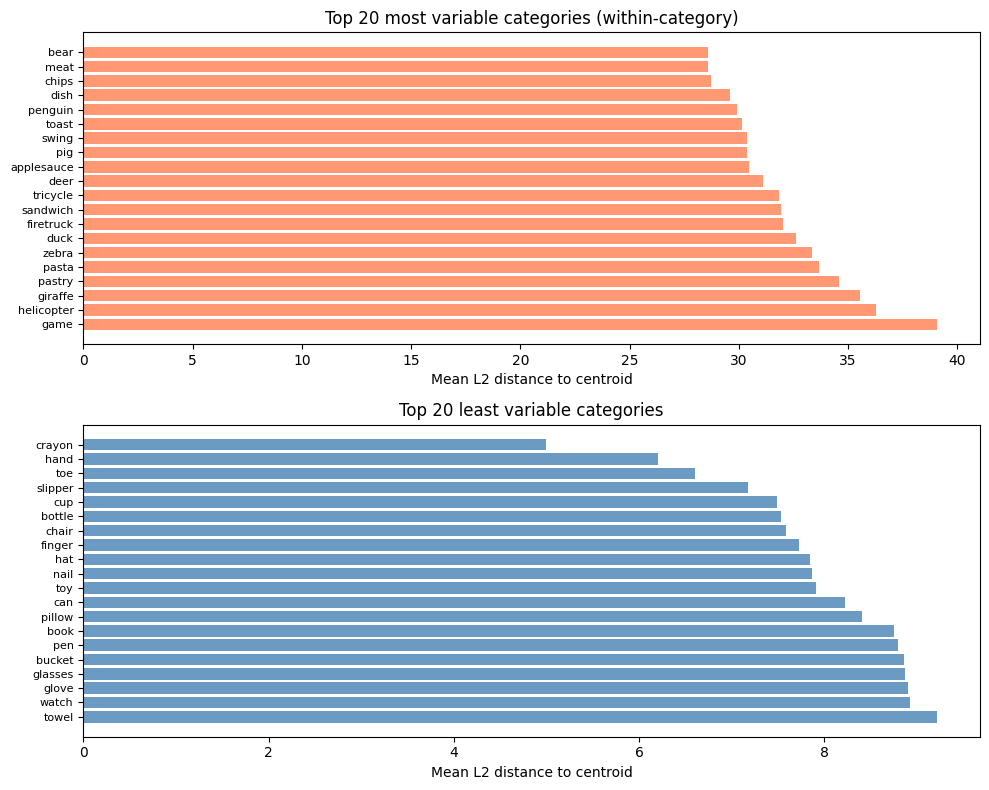

In [34]:
# Barplot: choose which config to plot (run "Optional: inspect" or load CSV first)
out_dir = Path(".")
plot_prefix = "bv_clip"  # or bv_dinov3, things_clip, things_dinov3
variability_df = pd.read_csv(out_dir / f"{plot_prefix}_within_category_variability.csv")
output_prefix = plot_prefix
n_show = 20
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

top_var = variability_df.head(n_show)
axes[0].barh(range(n_show), top_var["mean_dist_to_centroid"].values[::-1], color="coral", alpha=0.8)
axes[0].set_yticks(range(n_show))
axes[0].set_yticklabels(top_var["category"].values[::-1], fontsize=8)
axes[0].set_xlabel("Mean L2 distance to centroid")
axes[0].set_title(f"Top {n_show} most variable categories (within-category)")
axes[0].invert_yaxis()

bot_var = variability_df.tail(n_show)
axes[1].barh(range(n_show), bot_var["mean_dist_to_centroid"].values, color="steelblue", alpha=0.8)
axes[1].set_yticks(range(n_show))
axes[1].set_yticklabels(bot_var["category"].values, fontsize=8)
axes[1].set_xlabel("Mean L2 distance to centroid")
axes[1].set_title(f"Top {n_show} least variable categories")

plt.tight_layout()
plt.savefig(out_dir / f"{output_prefix}_within_category_variability_barplot.png", dpi=150, bbox_inches="tight")
plt.show()

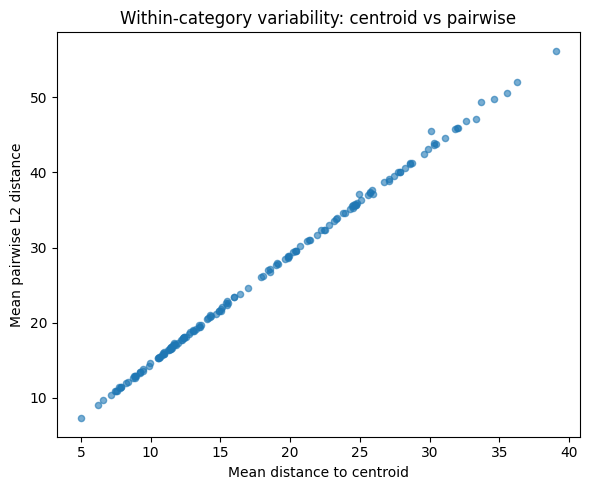

In [35]:
# Scatter: mean dist to centroid vs mean pairwise L2 (choose config to plot)
out_dir = Path(".")
plot_prefix = "bv_clip"
variability_df = pd.read_csv(out_dir / f"{plot_prefix}_within_category_variability.csv")
output_prefix = plot_prefix
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(variability_df["mean_dist_to_centroid"], variability_df["mean_pairwise_l2"], alpha=0.6, s=20)
ax.set_xlabel("Mean distance to centroid")
ax.set_ylabel("Mean pairwise L2 distance")
ax.set_title("Within-category variability: centroid vs pairwise")
plt.tight_layout()
plt.savefig(out_dir / f"{output_prefix}_within_category_centroid_vs_pairwise.png", dpi=150, bbox_inches="tight")
plt.show()

## 2D visualization (t-SNE) by CDI semantic category

For each **CDI semantic category** (e.g. animals, toys, food_drink), we gather all exemplar embeddings from object categories that map to that CDI category, run t-SNE on that subset, and plot one figure per CDI category. Points are colored by **object category** (word) so you can see the spread within the semantic group and how object categories cluster.

In [36]:
# CDI mapping is built per config inside the "Run all configs" cell.
# This cell is a no-op; t-SNE outputs are in {prefix}_tsne_by_cdi_category/ (see next cell).
pass


In [37]:
# t-SNE is generated in the "Run all configs" cell above for each of bv_clip, bv_dinov3, things_clip, things_dinov3.
# Output dirs: {prefix}_tsne_by_cdi_category/ (e.g. bv_clip_tsne_by_cdi_category/, things_dinov3_tsne_by_cdi_category/).
for prefix in ["bv_clip", "bv_dinov3", "things_clip", "things_dinov3"]:
    d = Path(f"{prefix}_tsne_by_cdi_category")
    n = len(list(d.glob("*.png"))) if d.exists() else 0
    print(f"  {prefix}: {n} t-SNE plots" if n else f"  {prefix}: (run Run all configs first)")


  bv_clip: 9 t-SNE plots
  bv_dinov3: 9 t-SNE plots
  things_clip: 9 t-SNE plots
  things_dinov3: 9 t-SNE plots


## Individual exemplar spread (violin) and t-SNE per object category with convex hull

**Violin plots:** One figure per CDI semantic category. Each figure shows BV and THINGS together: for each object category (within that CDI category), two violins—L2 distance-to-centroid per exemplar for BV embeddings and for THINGS embeddings (same embedding type, e.g. CLIP). Only object categories present in both BV and THINGS are included.

**Convex hull t-SNE:** One t-SNE per object category; subplots arranged in a grid by CDI category. Each subplot shows that category's exemplars in 2D with a convex hull.


In [38]:
# --- 1) Violin: per-exemplar distance to centroid, BV vs THINGS together (one plot per CDI category, clip + dinov3) ---
from scipy.spatial import ConvexHull
from sklearn.manifold import TSNE

violin_out_dir = Path("violin_plots")
violin_out_dir.mkdir(exist_ok=True)
for violin_embedding in ["clip", "dinov3"]:
    emb_bv, _ = load_embeddings_for_config("bv", violin_embedding)
    emb_th, _ = load_embeddings_for_config("things", violin_embedding)
    cdi_to_bv, cdi_cats_bv = build_cdi_mapping(emb_bv)
    cdi_to_th, cdi_cats_th = build_cdi_mapping(emb_th)
    cdi_categories_v = sorted(set(cdi_cats_bv) & set(cdi_cats_th))
    for violin_cdi in tqdm(cdi_categories_v, desc=f"Violin ({violin_embedding})"):
        obj_bv = set(cdi_to_bv[violin_cdi])
        obj_th = set(cdi_to_th[violin_cdi])
        obj_cats_common = sorted(obj_bv & obj_th)
        if not obj_cats_common:
            continue
        rows = []
        for cat in obj_cats_common:
            for embs, label in [(emb_bv, "BV"), (emb_th, "THINGS")]:
                X = embs[cat]
                centroid = X.mean(axis=0)
                dists = np.linalg.norm(X - centroid, axis=1)
                for d in dists:
                    rows.append({"category": cat, "dist_to_centroid": d, "source": label})
        df_v = pd.DataFrame(rows)
        n_cats = len(obj_cats_common)
        fig, ax = plt.subplots(figsize=(max(8, n_cats * 0.8), 5))
        sns.violinplot(data=df_v, x="category", y="dist_to_centroid", hue="source", ax=ax, split=False,
                       inner=None, linewidth=0, alpha=0.75)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_ylabel("L2 distance to centroid (per exemplar)")
        ax.set_title(f"Exemplar spread: {violin_cdi} (BV vs THINGS, {violin_embedding})")
        ax.legend(title="Source")
        plt.tight_layout()
        violin_fname = f"within_category_violin_bv_vs_things_{violin_embedding}_{violin_cdi.replace(' ', '_')}.png"
        violin_path = violin_out_dir.resolve() / violin_fname
        plt.savefig(violin_path, dpi=150, bbox_inches="tight")
        plt.close()
print(f"Saved violin plots (BV + THINGS) for clip and dinov3 to {violin_out_dir.resolve()}")

# --- 2) t-SNE per object category with convex hull, grid by CDI ---
hull_config = ("bv", "clip")  # (data_source, embedding_type)
hull_out_dir = Path(f"{hull_config[0]}_{hull_config[1]}_tsne_hull_by_cdi_category")
hull_out_dir.mkdir(exist_ok=True)
category_embeddings_h, _ = load_embeddings_for_config(*hull_config)
cdi_to_objects_h, cdi_categories_h = build_cdi_mapping(category_embeddings_h)
for cdi_cat in tqdm(cdi_categories_h, desc="Convex hull t-SNE"):
    obj_cats = cdi_to_objects_h[cdi_cat]
    n_obj = len(obj_cats)
    if n_obj == 0:
        continue
    n_cols = min(5, n_obj)
    n_rows = (n_obj + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axes = np.atleast_2d(axes)
    for idx, obj_cat in enumerate(obj_cats):
        r, c = idx // n_cols, idx % n_cols
        ax = axes[r, c]
        X = category_embeddings_h[obj_cat]
        if X.shape[0] < 3:
            ax.text(0.5, 0.5, f"{obj_cat}\n(n={X.shape[0]})", ha="center", va="center", transform=ax.transAxes)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.axis("off")
            continue
        perplexity = min(30, max(5, (X.shape[0] - 1) // 3))
        coords = TSNE(n_components=2, random_state=42, perplexity=perplexity).fit_transform(X)
        ax.scatter(coords[:, 0], coords[:, 1], alpha=0.6, s=15)
        try:
            hull = ConvexHull(coords)
            verts = np.vstack([coords[hull.vertices], coords[hull.vertices[0]]])
            ax.plot(verts[:, 0], verts[:, 1], "k-", lw=1, alpha=0.8)
            ax.fill(verts[:, 0], verts[:, 1], alpha=0.15, color="gray")
        except Exception:
            pass
        ax.set_title(f"{obj_cat}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
    for idx in range(n_obj, axes.size):
        r, c = idx // n_cols, idx % n_cols
        axes[r, c].axis("off")
    fig.suptitle(f"t-SNE + convex hull: {cdi_cat} ({hull_config[0]}_{hull_config[1]})", fontsize=12)
    plt.tight_layout()
    safe_name = cdi_cat.replace(" ", "_").replace("/", "-")
    plt.savefig(hull_out_dir / f"{safe_name}.png", dpi=150, bbox_inches="tight")
    plt.close()
print(f"Saved convex-hull t-SNE grids to {hull_out_dir}/")


Violin (dinov3): 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


Saved violin plots (BV + THINGS) for clip and dinov3 to /home/j7yang/babyview-projects/vss2026/object-detection/analysis/manuscript-2026/exemplar_variability_analyses/violin_plots


Convex hull t-SNE: 100%|██████████| 9/9 [01:39<00:00, 11.01s/it]

Saved convex-hull t-SNE grids to bv_clip_tsne_hull_by_cdi_category/


## Compare BV vs THINGS (side-by-side bar plots)

Load the four variability CSVs (per object category).
- **By CDI (aggregated):** `within_category_variability_compare_clip.png`, `..._dinov3.png`
- **Selected categories (top/bottom 20 by BV or by THINGS):** `..._clip_top20_by_bv.png`, `..._clip_bottom20_by_bv.png`, `..._clip_top20_by_things.png`, `..._clip_bottom20_by_things.png` (and same for dinov3)
- **All categories (each category = one row, BV vs THINGS bars):** `..._clip_all_categories.png`, `..._dinov3_all_categories.png`


In [39]:
# Run this after generating bv_clip, things_clip, bv_dinov3, things_dinov3 variability CSVs
out_dir = Path(".")
cdi_path = Path("../../../data/cdi_words.csv")
cdi_df = pd.read_csv(cdi_path)
word_to_cdi = dict(zip(cdi_df["uni_lemma"], cdi_df["category"]))

def obj_to_cdi(w):
    w = str(w).strip().lower()
    if w in word_to_cdi:
        return word_to_cdi[w]
    for v in [w.rstrip("s"), w.rstrip("es"), w.replace("_", " "), w.replace("-", " ")]:
        if v in word_to_cdi:
            return word_to_cdi[v]
    return None

def load_and_aggregate_bv_to_cdi(csv_path):
    """Load BV variability CSV (per object category) and aggregate to CDI level (mean mean_dist_to_centroid)."""
    if not Path(csv_path).exists():
        return None
    df = pd.read_csv(csv_path)
    df["cdi_category"] = df["category"].map(obj_to_cdi)
    df = df.dropna(subset=["cdi_category"])
    cdi_agg = df.groupby("cdi_category")["mean_dist_to_centroid"].mean().sort_index()
    return cdi_agg

def load_things_cdi(csv_path):
    """Load THINGS variability CSV (per object category) and aggregate to CDI level, same as BV."""
    if not Path(csv_path).exists():
        return None
    df = pd.read_csv(csv_path)
    df["cdi_category"] = df["category"].map(obj_to_cdi)
    df = df.dropna(subset=["cdi_category"])
    cdi_agg = df.groupby("cdi_category")["mean_dist_to_centroid"].mean().sort_index()
    return cdi_agg

def plot_compare(bv_series, things_series, title, out_path):
    if bv_series is None:
        print(f"Skipping {title}: missing BV CSV (run notebook with data_source='bv', embedding_type='clip' or 'dinov3')")
        return
    if things_series is None:
        print(f"Skipping {title}: missing THINGS CSV (run notebook with data_source='things', embedding_type='clip' or 'dinov3')")
        return
    common = bv_series.index.intersection(things_series.index).sort_values()
    if len(common) == 0:
        print(f"No common CDI categories for {title}")
        return
    bv_vals = [bv_series.get(c, np.nan) for c in common]
    th_vals = [things_series.get(c, np.nan) for c in common]
    x = np.arange(len(common))
    w = 0.35
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - w/2, bv_vals, w, label="BV", color="steelblue", alpha=0.9)
    ax.bar(x + w/2, th_vals, w, label="THINGS", color="coral", alpha=0.9)
    ax.set_xticks(x)
    ax.set_xticklabels(common, rotation=45, ha="right")
    ax.set_ylabel("Mean distance to centroid")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved {out_path}")

bv_clip = load_and_aggregate_bv_to_cdi(out_dir / "bv_clip_within_category_variability.csv")
th_clip = load_things_cdi(out_dir / "things_clip_within_category_variability.csv")
plot_compare(bv_clip, th_clip, "Within-category variability: BV CLIP vs THINGS CLIP (by CDI category)", 
             out_dir / "within_category_variability_compare_clip.png")

bv_dino = load_and_aggregate_bv_to_cdi(out_dir / "bv_dinov3_within_category_variability.csv")
th_dino = load_things_cdi(out_dir / "things_dinov3_within_category_variability.csv")
plot_compare(bv_dino, th_dino, "Within-category variability: BV DinoV3 vs THINGS DinoV3 (by CDI category)",
             out_dir / "within_category_variability_compare_dinov3.png")

# --- Per-object-category comparisons (selected + all categories) ---
def load_per_category(csv_path):
    if not Path(csv_path).exists():
        return None
    df = pd.read_csv(csv_path)[["category", "mean_dist_to_centroid"]]
    return df.rename(columns={"mean_dist_to_centroid": "val"})

def merge_bv_things(bv_df, th_df):
    if bv_df is None or th_df is None:
        return None
    m = bv_df.merge(th_df, on="category", how="inner", suffixes=("_bv", "_things"))
    m = m.rename(columns={"val_bv": "bv", "val_things": "things"})
    return m

def plot_side_by_side(df_sub, title, out_path, figsize=(10, 6)):
    n = len(df_sub)
    if n == 0:
        return
    y = np.arange(n)
    h = 0.35
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y - h/2, df_sub["bv"].values, h, label="BV", color="steelblue", alpha=0.9)
    ax.barh(y + h/2, df_sub["things"].values, h, label="THINGS", color="coral", alpha=0.9)
    ax.set_yticks(y)
    ax.set_yticklabels(df_sub["category"].values, fontsize=8)
    ax.set_xlabel("Mean distance to centroid")
    ax.set_title(title)
    ax.legend()
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved {out_path}")

N_SELECT = 20
for emb, label in [("clip", "CLIP"), ("dinov3", "DinoV3")]:
    bv_df = load_per_category(out_dir / f"bv_{emb}_within_category_variability.csv")
    th_df = load_per_category(out_dir / f"things_{emb}_within_category_variability.csv")
    if bv_df is None or th_df is None:
        continue
    m = merge_bv_things(bv_df, th_df)
    if m is None or len(m) == 0:
        continue
    # Top 20 by BV
    top_bv = m.nlargest(N_SELECT, "bv")
    plot_side_by_side(top_bv, f"Top {N_SELECT} most variable (by BV): BV vs THINGS {label}",
                     out_dir / f"within_category_variability_compare_{emb}_top20_by_bv.png")
    # Bottom 20 by BV
    bot_bv = m.nsmallest(N_SELECT, "bv")
    plot_side_by_side(bot_bv, f"Bottom {N_SELECT} least variable (by BV): BV vs THINGS {label}",
                     out_dir / f"within_category_variability_compare_{emb}_bottom20_by_bv.png")
    # Top 20 by THINGS
    top_th = m.nlargest(N_SELECT, "things")
    plot_side_by_side(top_th, f"Top {N_SELECT} most variable (by THINGS): BV vs THINGS {label}",
                     out_dir / f"within_category_variability_compare_{emb}_top20_by_things.png")
    # Bottom 20 by THINGS
    bot_th = m.nsmallest(N_SELECT, "things")
    plot_side_by_side(bot_th, f"Bottom {N_SELECT} least variable (by THINGS): BV vs THINGS {label}",
                     out_dir / f"within_category_variability_compare_{emb}_bottom20_by_things.png")
    # All categories (tall figure)
    m_sorted = m.sort_values("bv", ascending=False).reset_index(drop=True)
    height = max(8, len(m_sorted) * 0.22)
    plot_side_by_side(m_sorted, f"All categories: BV vs THINGS {label} (n={len(m_sorted)})",
                     out_dir / f"within_category_variability_compare_{emb}_all_categories.png", figsize=(10, height))


Saved within_category_variability_compare_clip.png
Saved within_category_variability_compare_dinov3.png
Saved within_category_variability_compare_clip_top20_by_bv.png
Saved within_category_variability_compare_clip_bottom20_by_bv.png
Saved within_category_variability_compare_clip_top20_by_things.png
Saved within_category_variability_compare_clip_bottom20_by_things.png
Saved within_category_variability_compare_clip_all_categories.png
Saved within_category_variability_compare_dinov3_top20_by_bv.png
Saved within_category_variability_compare_dinov3_bottom20_by_bv.png
Saved within_category_variability_compare_dinov3_top20_by_things.png
Saved within_category_variability_compare_dinov3_bottom20_by_things.png
Saved within_category_variability_compare_dinov3_all_categories.png
